In [1]:

from __future__ import print_function   

import os
import numpy as np
import pylab as py


from local_minima import *
from critical_points_lines import *

import torch.nn.functional as F
from timeit import default_timer
from utilities3 import *


In [2]:
TRAIN_PATH = 'piececonst_r421_N1024_smooth1.mat'
TEST_PATH = 'piececonst_r421_N1024_smooth2.mat'

ntrain = 1000
ntest = 100

batch_size = 10

r = 5
h = int(((421 - 1)/r) + 1)
s = h

reader = MatReader(TRAIN_PATH)
x_train = reader.read_field('coeff')[:ntrain,::r,::r][:,:s,:s].reshape(ntrain,s*s)
y_train = reader.read_field('sol')[:ntrain,::r,::r][:,:s,:s].reshape(ntrain,s*s)
reader.load_file(TEST_PATH)
x_test = reader.read_field('coeff')[:ntest,::r,::r][:,:s,:s].reshape(ntest,s*s)
y_test = reader.read_field('sol')[:ntest,::r,::r][:,:s,:s].reshape(ntest,s*s)


print(x_test.shape, y_test.shape)


x_normalizer = UnitGaussianNormalizer(x_test)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_test)
y_test = y_normalizer.encode(y_test)

# x_normalizer = UnitGaussianNormalizer(x_train)
# x_train = x_normalizer.encode(x_train)
# x_test = x_normalizer.encode(x_test)
# 
# y_normalizer = UnitGaussianNormalizer(y_train)
# y_train = y_normalizer.encode(y_train)
# y_test = y_normalizer.encode(y_test)


grids = []
grids.append(np.linspace(0, 1, s))
grids.append(np.linspace(0, 1, s))
grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T
grid = grid.reshape(1,s*s,2)
grid = torch.tensor(grid, dtype=torch.float)
x_test_full = torch.cat([x_test.reshape(ntest,s*s,1), grid.repeat(ntest,1,1)], dim=2)


torch.Size([100, 7225]) torch.Size([100, 7225])


In [3]:
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test_full, y_test), batch_size=batch_size, shuffle=False)
x, y = next(iter(test_loader))

In [37]:
X, Y = torch.meshgrid(torch.linspace(0, 1, s), torch.linspace(0, 1, s))
t_idx = 2

Ux = -torch.diff(y[t_idx].reshape(85, 85), dim=0, prepend=torch.zeros(1, 85)).cpu().numpy()
Uy = torch.diff(y[t_idx].reshape(85, 85), dim=1, prepend=torch.zeros(85, 1)).cpu().numpy()


xdomain, ydomain = np.linspace(0, 1, s), np.linspace(0, 1, s)

N_sample = 4
xdomain, ydomain, Ux, Uy = xdomain[N_sample:-N_sample], ydomain[N_sample:-N_sample], Ux[N_sample:-N_sample, N_sample:-N_sample], Uy[N_sample:-N_sample, N_sample:-N_sample]

U = np.sqrt(Ux**2 + Uy**2)


Navg_x = 20 #12  # number of points taken when calculating local average (one sided along x direction)
Navg_y = 20 #12  # number of points taken when calculating local average (one sided along y direction)
Npoints_th = 0.1
th_thin = 0.1  # Thereshold for thinning critical points (i.e. two points with Euclidean dist < th_thin are counted only once)

print(U.shape, xdomain.shape)

ind_1 = adj_local_minima(xdomain,ydomain,U)                   # Find indices of the local minimas. Correct for corner points
# print(ind_1)
c_type = critical_point_type(xdomain, ydomain, Ux, Uy, ind_1)
# ind_2 = ind_1
ind_2 = thin_local_minima(xdomain,ydomain,ind_1,th_thin)    # Ignore points that are close to each other (select only one)
avF = avgF_at_local_minima(U,ind_2,Navg_x,Navg_y)            # Calculate local averages
# ind_sort = np.flip(np.argsort(avF))                         # sort from maximum average value to minimum average value
ind_sort = np.argsort(avF)                                   # sort from minimum average value to maximum average value
Npoints = Npoint_estimate(avF[ind_sort], Npoints_th,1)       # Estimate the number of critical points
ind_3 = adj_with_rank(ind_2, ind_sort, Npoints)              # Clip to the estimated number of critical points
ind_adj = ind_3                       # Local average raknin algorithm needs more work. It is skipped for now

print(ind_adj)
# py.streamplot(xdomain, ydomain, Ux, Uy, color=U)

# stream_lines(xdomain,ydomain,Ux,Uy,ind_adj)


(77, 77) (77,)
m = 0, ratio = 1.000, flag = 0 

m = 1, ratio = 1.581, flag = 0 

m = 2, ratio = 1.800, flag = 0 

m = 3, ratio = 1.949, flag = 0 

m = 4, ratio = 2.331, flag = 0 

m = 5, ratio = 3.033, flag = 0 

(array([75, 75, 43, 72,  8, 43]), array([24, 38, 11, 74, 34, 34]))


Text(0.5, 1.0, 'Vector Topology')

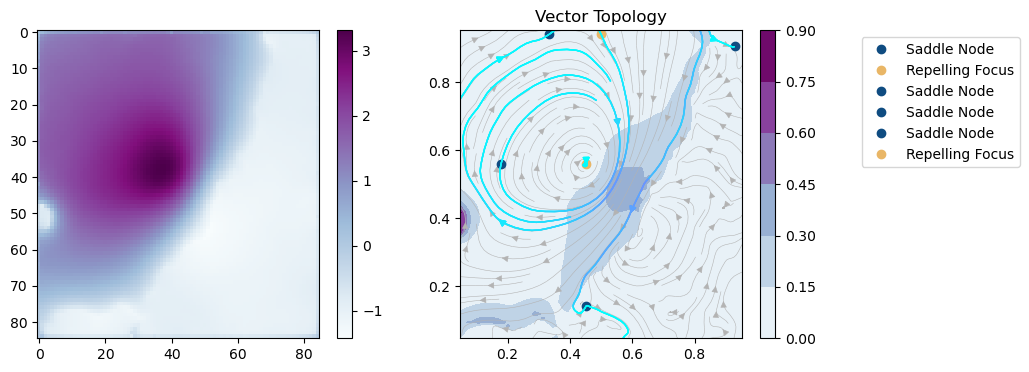

In [38]:
py.figure(figsize=(10, 4)) 

py.subplot(121)
py.imshow(y[t_idx].reshape(85, 85).flip(0).cpu().numpy(), aspect='auto', cmap='BuPu')
py.colorbar()
# py.contourf(xdomain, ydomain, y[t_idx].reshape(85, 85).cpu().numpy())

py.subplot(122)
py.contourf(xdomain, ydomain, U, cmap='BuPu')
# py.imshow(U, aspect='auto')
# py.imshow(U)
py.colorbar()

py.streamplot(xdomain, ydomain, Ux, Uy,color = [.7, .7 , .7],density = 1.2, linewidth = 0.4)
stream_lines(xdomain,ydomain,Ux,Uy,ind_adj, cmap='cool')
py.legend(bbox_to_anchor=(1.4, 1.),)
py.title("Vector Topology")
